# Coronavirus (COVID-19) England Map
## David Beavan @DavidBeavan
## Licence: MIT. Sources: see below
## Scroll down for maps
## Notes
* This does what other maps do not, it shows cases per population
* England only at the moment (I would like to merge Scotland, Wales and NI)
* UK dataset https://www.gov.uk/government/publications/covid-19-track-coronavirus-cases 'UTLA cases table'
* Maps reported cases and those with location
* The dataset above may not always be up to date
* Population estimates are from ONS, mid-2018
* I am not distributing any data, but it will be fetched
* The government has been actively updating the data made available, this might break this tool

In [1]:
# load libraries
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import shutil
import io
import zipfile
import datetime
%matplotlib inline

In [2]:
# Prep data
# Data is not packaged with code, Will download from sources and save for future runs


def prep_data():
    data_base_dir = Path('data/primary_sources')
    data_base_dir.mkdir(parents=True, exist_ok=True)

    try:
        # https://geoportal.statistics.gov.uk/datasets/counties-and-unitary-authorities-december-2019-boundaries-uk-bgc
        # This file contains the digital vector boundaries for Counties and Unitary Authorities in the United Kingdom, as at December 2019
        # Office for National Statistics licensed under the Open Government Licence v.3.0
        # Contains OS data © Crown copyright and database right 2019

        data_sub_dir = data_base_dir.joinpath('utla_boundaries')

        if not data_sub_dir.is_dir():
            r = requests.get(
                'https://opendata.arcgis.com/datasets/29827d4c079349888acd7db3f84e3449_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D')

            data_sub_dir.mkdir(parents=True)

            myzipfile = zipfile.ZipFile(io.BytesIO(r.content))
            myzipfile.extractall(data_sub_dir)
    except:
        print('Error: Could not fetch utla_boundaries')

    try:
        # https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland
        # Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland as at mid-2018
        # Office for National Statistics licensed under the Open Government Licence
        # Crown copyright 2019

        data_sub_dir = data_base_dir.joinpath('population_estimates')

        if not data_sub_dir.is_dir():
            r = requests.get('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fpopulationestimatesforukenglandandwalesscotlandandnorthernireland%2fmid20182019laboundaries/ukmidyearestimates20182019ladcodes.xls')

            data_sub_dir.mkdir(parents=True)

            file = open(data_sub_dir.joinpath(
                'ukmidyearestimates20182019ladcodes.xls'), 'wb')
            file.write(r.content)
            file.close()
    except:
        print('Error: Could not fetch population_estimates')

    try:
        # https://www.arcgis.com/home/item.html?id=b684319181f94875a6879bbc833ca3a6
        # Data is based on cases reported to PHE and matched to ONS administrative geography codes and names to generate geographic case counts.
        # Contains Ordnance Survey data © Crown copyright and database right 2020.  Contains National Statistics data © Crown copyright and database right 2020

        data_sub_dir = data_base_dir.joinpath('countyuas_cases')

        if not data_sub_dir.is_dir():
            r = requests.get(
                'https://www.arcgis.com/sharing/rest/content/items/b684319181f94875a6879bbc833ca3a6/data')

            data_sub_dir.mkdir(parents=True)

            file = open(data_sub_dir.joinpath('countyuas_cases.csv'), 'wb')
            file.write(r.content)
            file.close()
    except:
        print('Error: Could not fetch covid cases')


prep_data()

In [3]:
# Load Upper Tier Local Authority (UTLA) AKA Counties and unitary Authorities boundary shapefile
utla_df = gpd.read_file(Path(
    "data/primary_sources/utla_boundaries/Counties_and_Unitary_Authorities_December_2019_Boundaries_UK_BGC.shp"))

# Remove Scotland and NI (for now, this is only parsing England data)
utla_df = utla_df[~utla_df['ctyua19cd'].str.contains('^[SN]')]

# Remove Wales (for now, this is only parsing England data)
utla_df = utla_df[utla_df['ctyua19nmw'].isnull()]

# Drop unused columns
utla_df.drop(columns=['objectid', 'ctyua19nmw', 'bng_e',
                      'bng_n', 'long', 'lat', 'st_lengths'], inplace=True)

# Index on ctyua19cd AKA region code
utla_df.set_index('ctyua19cd', inplace=True)

In [4]:
# Preview data
# utla_df.head()

In [5]:
# Preview map

# ax = utla_df.plot()
# ax.axis('off')

In [6]:
# Preview London map

# ax = utla_df.plot()
# ax.set_xlim([500000, 560000])
# ax.set_ylim([150000, 210000])
# ax.axis('off')

In [7]:
# Load population estimates mid-2018
pop_df = pd.read_excel(Path("data/primary_sources/population_estimates/ukmidyearestimates20182019ladcodes.xls"),
                       header=4, sheet_name='MYE3', usecols='A:O')

# Drop unused columns
pop_df.drop(columns=['Name', 'Geography1', 'Estimated Population  mid-2017', 'Births', 'Deaths', 'Births minus Deaths', 'Internal Migration Inflow', 'Internal Migration Outflow',
                     'Internal Migration Net', 'International Migration Inflow', 'International Migration Outflow', 'International Migration Net', 'Other'], inplace=True)

# Rename population column
pop_df.rename(
    columns={'Estimated Population  mid-2018': 'population'}, inplace=True)

# Index on Code AKA region code
pop_df.set_index('Code', inplace=True)

In [8]:
# Preview data
# pop_df.head()

In [9]:
# Check all regions in utla have population estimates

if len(list(set(utla_df.index).difference(pop_df.index))) != 0:
    print('Error: Not all regions have population data')

# There will be regions from the population estimates that do not have an entry in utla.
# The population data has larger areas than utlas, e.g. nations, it also has Scotland, NI and Wales

In [10]:
# Join the population estimates to the utla regions
utla_pop_df = utla_df.join(pop_df)

In [11]:
# The England covid-19 data merges Hackney and City of London, and Cornwall and Isles of Scilly, we must do the same


def merge_areas(df, area1, area2, new_index, new_title):
    # Get first area info, and delete it
    area1_rows = df.loc[df['ctyua19nm'] == area1]
    if len(area1_rows) != 1:
        print('Error: Cannot find entry')
    area1_row = area1_rows.iloc[0]
    df = df[df['ctyua19nm'] != area1]

    # Get second area info, and delete it
    area2_rows = df.loc[df['ctyua19nm'] == area2]
    if len(area2_rows) != 1:
        print('Error: Cannot find entry')
    area2_row = area2_rows.iloc[0]
    df = df[df['ctyua19nm'] != area2]

    # Merge areas and insert new combigned area
    new_shape = area1_row['geometry'].union(area2_row['geometry'])
    new_row = [new_title, area1_row['st_areasha'] + area2_row['st_areasha'],
               new_shape, area1_row['population'] + area2_row['population']]
    df.loc[new_index] = new_row

    return df


# merge areas, give them the index code (e.g. E09000012) used by the Government covid cases dataset
utla_pop_df = merge_areas(utla_pop_df, 'Hackney', 'City of London',
                          'E09000012', 'Hackney and City of London')
utla_pop_df = merge_areas(utla_pop_df, 'Cornwall', 'Isles of Scilly',
                          'E06000052', 'Cornwall and Isles of Scilly')

In [12]:
# Preview data
# utla_pop_df.head()

In [13]:
def show_map(df, variable, title, size, cmap, limits=None):

    # Prep plot
    fig, ax = plt.subplots(1, figsize=size, facecolor='LightGray')

    # Zoom in to limits, if given
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])

    # Plot map
    df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='gray')

    # Remove the axis
    ax.axis('off')

    # Add title
    ax.set_title(title, fontdict={
                 'fontsize': 'xx-large', 'fontweight': 'bold'})

    # Add attributions
    ax.annotate('Code: David Beavan Twitter:@DavidBeavan GitHub:https://github.com/DavidBeavan/coronavirus_covid-19\nPopulation estimates mid-2018\nSource: Office for National Statistics licensed under the Open Government Licence\nContains OS data © Crown copyright and database right 2019',
                xy=(0.02, .08), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize='medium', color='black')

    # Add legend
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=0, vmax=variable.max()))
    sm._A = []
    cbar = fig.colorbar(sm)

    # Save map
    # fig.savefig('map.png', dpi=300)

In [14]:
# Population map
# show_map(utla_pop_df, utla_pop_df['population'] / 1000,
#          'Population (raw) (1,000s)', (12, 12), 'Blues')

In [15]:
# Population map London
# show_map(utla_pop_df, utla_pop_df['population'] / 1000, 'Population (raw) London (1,000s)',
#          (12, 12), 'Blues', ([500000, 560000], [150000, 210000]))

In [16]:
# Population density map
# show_map(utla_pop_df, (utla_pop_df['population'] / 1000) / (utla_pop_df['st_areasha'] /
#                                                             1000000), 'Population (density) (1,000s per km2)', (12, 12), 'Purples')

In [17]:
# Population density map London
# show_map(utla_pop_df, (utla_pop_df['population'] / 1000) / (utla_pop_df['st_areasha'] / 1000000),
#          'Population (density) London (1,000s per km2)', (12, 12), 'Purples', ([500000, 560000], [150000, 210000]))

In [18]:
# Load population estimates mid-2018
countyuas_cases_df = pd.read_csv(
    Path("data/primary_sources/countyuas_cases/countyuas_cases.csv"))

# Drop unneeded columns
countyuas_cases_df.drop(columns=['GSS_NM'], inplace=True)

# Index on GSS_CD AKA region code
countyuas_cases_df.set_index('GSS_CD', inplace=True)

In [19]:
# Preview data
# countyuas_cases_df.head()

In [20]:
# Check all regions in utla have covid case data

if len(list(set(utla_pop_df.index).difference(countyuas_cases_df.index))) != 0:
    print('Error: Not all regions have covid case data')

# Check all regions in covid case data have utla area
if len(list(set(countyuas_cases_df.index).difference(utla_pop_df.index))) != 0:
    print('Error: Not all regions have covid case data')

In [21]:
# Join the covid cases to utla regions
utla_pop_cases_df = utla_pop_df.join(countyuas_cases_df)

# Add new column to summerise total cases per 1,000 ppl
utla_pop_cases_df['cases_per_1000'] = (
    utla_pop_cases_df['TotalCases'] / (utla_pop_cases_df['population'] / 1000))

In [22]:
# Preview data
# utla_pop_cases_df.head()

In [23]:
date_fetched = '\nData fetched ' + datetime.date.today().isoformat() + \
    ' may be delayed'

# Maps

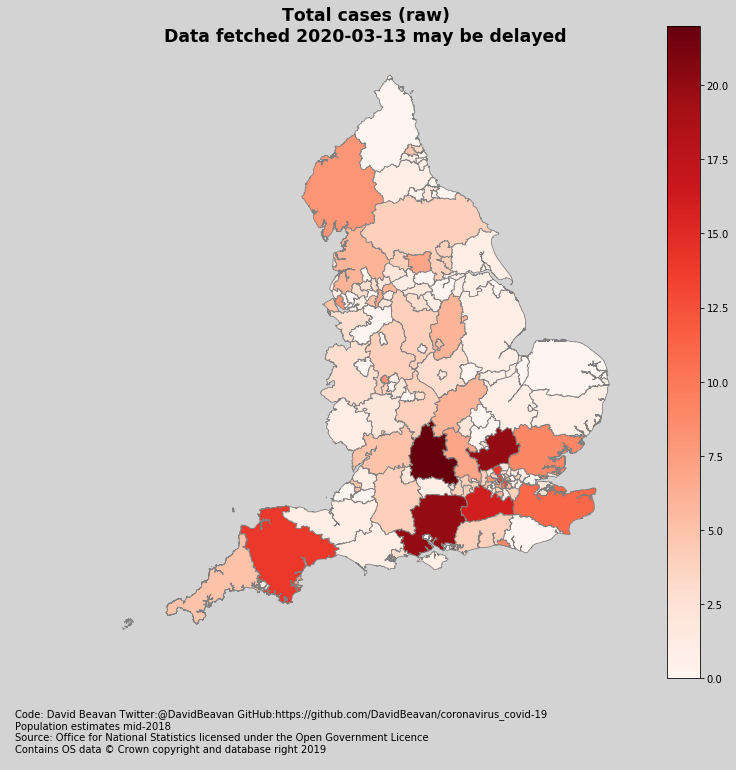

In [24]:
# Cases map
show_map(utla_pop_cases_df, utla_pop_cases_df['TotalCases'],
         'Total cases (raw)' + date_fetched, (12, 12), 'Reds')

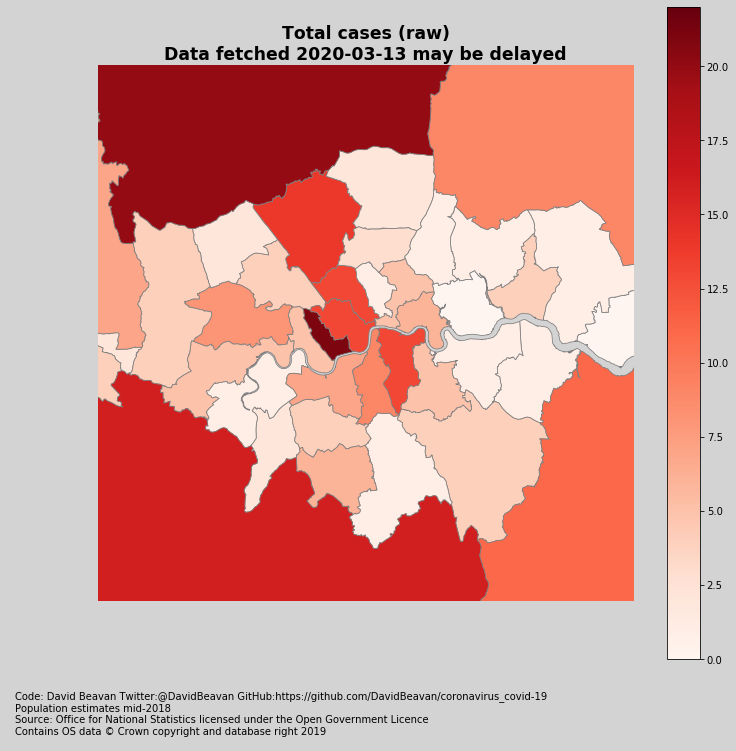

In [25]:
# Cases map London
show_map(utla_pop_cases_df, utla_pop_cases_df['TotalCases'], 'Total cases (raw)' +
         date_fetched, (12, 12), 'Reds', ([500000, 560000], [150000, 210000]))

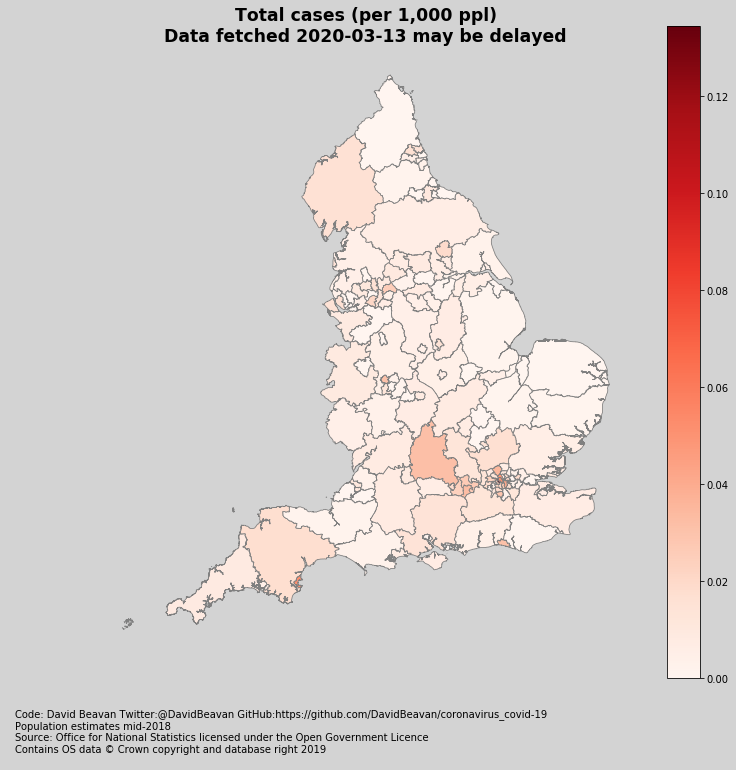

In [26]:
# Cases map per 1,000 ppl
show_map(utla_pop_cases_df, utla_pop_cases_df['cases_per_1000'],
         'Total cases (per 1,000 ppl)' + date_fetched, (12, 12), 'Reds')

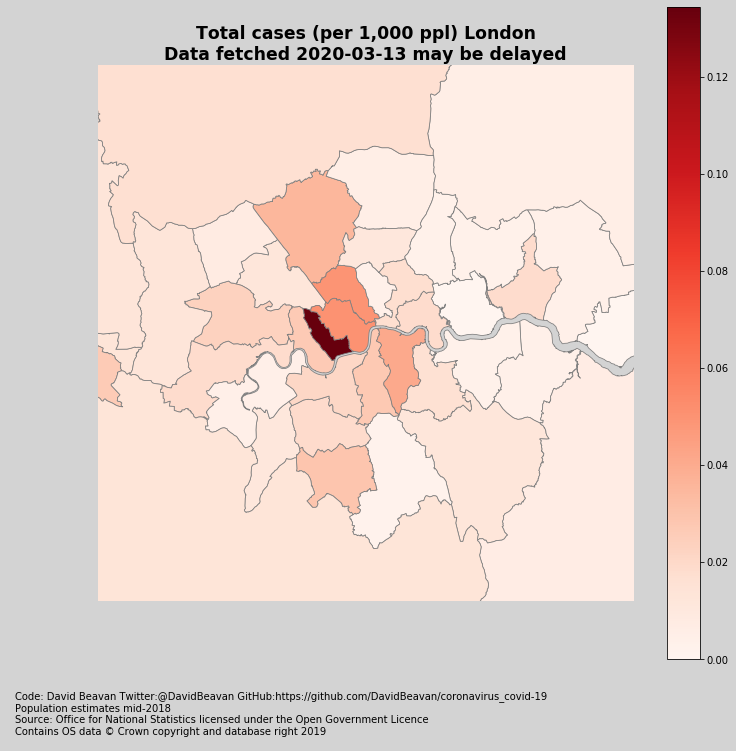

In [27]:
# Cases map per 1,000 ppl London
show_map(utla_pop_cases_df, utla_pop_cases_df['cases_per_1000'], 'Total cases (per 1,000 ppl) London' +
         date_fetched, (12, 12), 'Reds', ([500000, 560000], [150000, 210000]))

# Tables

In [28]:
# Number of cases (where location is known)
# 2020-3-12= 434
utla_pop_cases_df['TotalCases'].sum()

535

In [29]:
# Top cases (raw)
utla_pop_cases_df.sort_values(['TotalCases'], ascending=False)[
    ['ctyua19nm', 'population', 'TotalCases']].head(10)

,ctyua19nm,population,TotalCases
E10000025,Oxfordshire,687524.0,22
E09000020,Kensington and Chelsea,156197.0,21
E10000014,Hampshire,1376316.0,20
E10000015,Hertfordshire,1184365.0,20
E10000030,Surrey,1189934.0,16
E09000003,Barnet,392140.0,14
E10000008,Devon,795286.0,14
E09000028,Southwark,317256.0,13
E09000033,Westminster,255324.0,13
E09000007,Camden,262226.0,13


In [30]:
# Bottom cases (raw)
utla_pop_cases_df.sort_values(['TotalCases'], ascending=False)[
    ['ctyua19nm', 'population', 'TotalCases']].tail(10)

,ctyua19nm,population,TotalCases
E06000024,North Somerset,213919.0,0
E06000056,Central Bedfordshire,283606.0,0
E08000036,Wakefield,345038.0,0
E06000055,Bedford,171623.0,0
E06000049,Cheshire East,380790.0,0
E09000025,Newham,352005.0,0
E06000034,Thurrock,172525.0,0
E06000045,Southampton,252796.0,0
E06000044,Portsmouth,215133.0,0
E06000001,Hartlepool,93242.0,0


In [31]:
# Top cases (per 1,000 ppl)
utla_pop_cases_df.sort_values(['cases_per_1000', 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', 'cases_per_1000']].head(10)

,ctyua19nm,population,cases_per_1000
E09000020,Kensington and Chelsea,156197.0,0.134446
E06000027,Torbay,135780.0,0.051554
E09000033,Westminster,255324.0,0.050916
E09000007,Camden,262226.0,0.049576
E09000028,Southwark,317256.0,0.040976
E09000003,Barnet,392140.0,0.035702
E06000036,Bracknell Forest,121676.0,0.032874
E10000025,Oxfordshire,687524.0,0.031999
E06000043,Brighton and Hove,290395.0,0.030992
E08000031,Wolverhampton,262008.0,0.030533


In [32]:
# Bottom cases (per 1,000 ppl)
utla_pop_cases_df.sort_values(['cases_per_1000', 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', 'cases_per_1000']].tail(10)

,ctyua19nm,population,cases_per_1000
E08000006,Salford,254408.0,0.0
E08000028,Sandwell,327378.0,0.0
E08000029,Solihull,214909.0,0.0
E08000023,South Tyneside,150265.0,0.0
E06000045,Southampton,252796.0,0.0
E08000013,St. Helens,180049.0,0.0
E06000021,Stoke-on-Trent,255833.0,0.0
E06000020,Telford and Wrekin,177799.0,0.0
E06000034,Thurrock,172525.0,0.0
E08000036,Wakefield,345038.0,0.0


In [33]:
# Remove covid-19 case data, so fresh data is fetched

# Delete old backup
backup_dir = Path('data/primary_sources_bak_' +
                  datetime.date.today().isoformat())
if backup_dir.exists():
    shutil.rmtree(backup_dir)

# Make new backup
shutil.copytree(Path('data/primary_sources/'), backup_dir)

# Remove existing covid case data
if Path('data/primary_sources/countyuas_cases/countyuas_cases.csv').exists():
    Path('data/primary_sources/countyuas_cases/countyuas_cases.csv').unlink()
if Path('data/primary_sources/countyuas_cases').exists():
    Path('data/primary_sources/countyuas_cases').rmdir()